In [4]:
%matplotlib inline

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import numba

(array([  4.,  22.,  65., 153., 211., 246., 176.,  89.,  27.,   7.]),
 array([-0.67278537, -0.33911519, -0.005445  ,  0.32822518,  0.66189536,
         0.99556554,  1.32923572,  1.6629059 ,  1.99657609,  2.33024627,
         2.66391645]),
 <BarContainer object of 10 artists>)

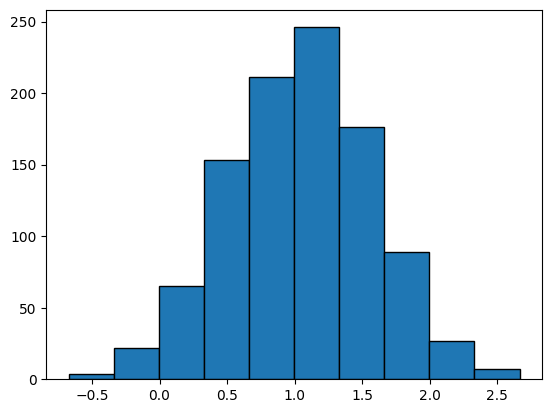

In [15]:

data = ((np.random.randn(1_000) + 2)  / 12) * np.pi * 2
fig, ax = plt.subplots()
ax.hist(data, edgecolor = 'k')

In [16]:

def HermansRasson2T_V1(sample):
    n = sample.size
    total = 0
    for i in range(n):
        for j in range(n):
            total = total + abs(abs(sample[i]-sample[j])-np.pi)-(np.pi/2)
            total = total - (2.895*(abs(np.sin(sample[i]-sample[j]))-(2/np.pi)))
    T = total/n
    return T



In [21]:
@numba.jit()
def HermansRasson2T_V2(sample):
    n = sample.size
    total = 0
    for i in range(n):
        for j in range(n):
            total = total + abs(abs(sample[i]-sample[j])-np.pi)-(np.pi/2)
            total = total - (2.895*(abs(np.sin(sample[i]-sample[j]))-(2/np.pi)))
    T = total/n
    return T


In [105]:

def HermansRasson2T_V3(sample):
    d = sample[None, :] - sample[:, None]
    T = np.sum(np.abs(np.abs(d) - np.pi) - (np.pi / 2) - 2.895 * (np.abs(np.sin(d)) - (2 / np.pi))) / sample.size
    return T


In [106]:
print(HermansRasson2T_V1(data))
print(HermansRasson2T_V2(data))
print(HermansRasson2T_V3(data))

1368.0969919426423
1368.0969919426423
1368.0969919480217


In [107]:
%timeit HermansRasson2T_V1(data)

1.27 s ± 2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
%timeit HermansRasson2T_V2(data)

9.21 ms ± 2.17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [109]:
%timeit HermansRasson2T_V3(data)

15 ms ± 80.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
1260 / 9.21

136.80781758957653

In [28]:
a = np.arange(4)
b = np.arange(4) * 10
print(a, b)

[0 1 2 3] [ 0 10 20 30]


In [29]:
a[:, None] + b[None, :]

array([[ 0, 10, 20, 30],
       [ 1, 11, 21, 31],
       [ 2, 12, 22, 32],
       [ 3, 13, 23, 33]])

In [110]:
def HermansRasson2P_V1(sample, univals = 1000):
    n = sample.size
    testset = np.zeros(univals)
    for f in range(univals):
        data1 = np.random.rand(n) * 2*np.pi
        testset[f] = HermansRasson2T_V2(data1)
    Tsample = HermansRasson2T_V2(sample)

    counter = 1
    for j in range(univals):
        if testset[j] >= Tsample:
            counter = counter + 1
    p = counter / (univals+1)
    return p

In [111]:
def HermansRasson2P_V2(sample, univals = 1000, seed=None):
    rng = np.random.default_rng(seed=seed)
    Tsample = HermansRasson2T_V2(sample)
    n = sample.size
    testset = np.zeros(univals)
    for f in range(univals):
        data1 = rng.uniform(size=n, low=0, high=2*np.pi)
        testset[f] = HermansRasson2T_V2(data1)
    p = (np.sum(testset > Tsample) + 1) / (univals + 1)
    return p

In [112]:
def HermansRasson2P_V2(sample, univals = 1000, seed=None):
    rng = np.random.default_rng(seed=seed)
    Tsample = HermansRasson2T_V2(sample)
    n = sample.size
    testset = np.zeros(univals)
    for f in range(univals):
        data1 = rng.uniform(size=n, low=0, high=2*np.pi)
        testset[f] = HermansRasson2T_V2(data1)
    p = (np.sum(testset > Tsample) + 1) / (univals + 1)
    return p

In [126]:
@numba.jit()
def HermansRasson2P_V3(sample, univals = 1000, seed=None):
    
    rng = np.random.default_rng(seed=seed)
    Tsample = HermansRasson2T_V2(sample)
    n = sample.size
    testset = np.zeros(univals)
    for f in numba.prange(univals):
        data1 = rng.uniform(size=n, low=0, high=2*np.pi)
        testset[f] = HermansRasson2T_V2(data1)
    p = (np.sum(testset > Tsample) + 1) / (univals + 1)
    return p

In [127]:
print(HermansRasson2P_V1(data, univals = 10))
print(HermansRasson2P_V2(data, univals = 10))
print(HermansRasson2P_V3(data, univals = 10))


0.09090909090909091
0.09090909090909091


/tmp/ipykernel_3754/947443828.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "HermansRasson2P_V3" failed type inference due to: Unknown attribute 'default_rng' of type Module(<module 'numpy.random' from '/home/samuel/.virtualenvs/py3.10/lib/python3.10/site-packages/numpy/random/__init__.py'>)

File "../../../tmp/ipykernel_3754/947443828.py", line 4:
<source missing, REPL/exec in use?>

During: typing of get attribute at /tmp/ipykernel_3754/947443828.py (4)

File "../../../tmp/ipykernel_3754/947443828.py", line 4:
<source missing, REPL/exec in use?>

  @numba.jit()
/tmp/ipykernel_3754/947443828.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "HermansRasson2P_V3" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../tmp/ipykernel_3754/947443828.py", line 8:
<source missing, REPL/exec in use?>

  @numba.ji

0.09090909090909091


In [128]:
%timeit HermansRasson2P_V1(data, univals=10)

145 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [129]:
%timeit HermansRasson2P_V2(data, univals=10)

144 ms ± 335 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [130]:
%timeit HermansRasson2P_V3(data, univals=10)

144 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
